# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
plt.style.use('ggplot')
%load_ext blackcellmagic
# %%black

# Data Preparation

# Import and Update tables

In [2]:
# import and update table card
card = pd.read_csv(
    "bank_data_loan_default/card.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
card.issued = card.issued.str.strip("00:00:00")
card.type = card.type.map({"gold": 2, "classic": 1, "junior": 0})
card.head()


,card_id,disp_id,type,issued
0,1005,9285,1,931107
1,104,588,1,940119
2,747,4915,1,940205
3,70,439,1,940208
4,577,3687,1,940215


In [3]:
# import and update table account
account = pd.read_csv(
    "bank_data_loan_default/account.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
)
account.date = account.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
account.head()


,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,1993-01-01
1,3818,74,POPLATEK MESICNE,1993-01-01
2,704,55,POPLATEK MESICNE,1993-01-01
3,2378,16,POPLATEK MESICNE,1993-01-01
4,2632,24,POPLATEK MESICNE,1993-01-02


In [4]:
# import and update table disp
disp = pd.read_csv(
    "bank_data_loan_default/disp.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
disp = disp[disp.type == "OWNER"]
disp.rename(columns={"type": "type_disp"}, inplace=True)
disp.head()


,disp_id,client_id,account_id,type_disp
0,1,1,1,OWNER
1,2,2,2,OWNER
3,4,4,3,OWNER
5,6,6,4,OWNER
6,7,7,5,OWNER


In [5]:
# import and update table client
client = pd.read_csv(
    "bank_data_loan_default/client.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
client["month"] = client.birth_number.apply(
    lambda x: x // 100 % 100, convert_dtype=True, args=()
)
client["year"] = client.birth_number.apply(
    lambda x: x // 100 // 100, convert_dtype=True, args=()
)
client["age"] = 99 - client.year
client["sex"] = client.month.apply(lambda x: (x - 50) < 0, convert_dtype=True, args=())
client.sex = client.sex.astype(int)  # 0 for female, 1 for male
client.drop(["birth_number", "month", "year"], axis=1, inplace=True)
client.head()


,client_id,district_id,age,sex
0,1,18,29,0
1,2,1,54,1
2,3,1,59,0
3,4,5,43,1
4,5,5,39,0


In [6]:
# import and update table district
district = pd.read_csv(
    "bank_data_loan_default/district.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
district.drop(["A2", "A3"], axis=1, inplace=True)
district.head()


,A1,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [7]:
# import and update table order
order = pd.read_csv(
    "bank_data_loan_default/order.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
order.drop(["bank_to", "account_to", "order_id"], axis=1, inplace=True)
order.k_symbol.fillna("No_symbol")
order.k_symbol = order.k_symbol.str.replace(" ", "No_symbol")
order = order.groupby(["account_id", "k_symbol"]).mean().unstack()
order = order.fillna(0)
order.columns = order.columns.droplevel()
order.reset_index(level="account_id", col_level=1, inplace=True)
order.rename_axis("", axis="columns", inplace=True)
order.rename(
    index=None,
    columns={
        "LEASING": "order_amount_LEASING",
        "No_symbol": "order_amount_No_symbol",
        "POJISTNE": "order_amount_POJISTNE",
        "SIPO": "order_amount_SIPO",
        "UVER": "order_amount_UVER",
    },
    inplace=True,
)
order.head()


,account_id,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER
0,1,0.0,0.0,0.0,2452.0,0.0
1,2,0.0,0.0,0.0,7266.0,3372.7
2,3,0.0,327.0,3539.0,1135.0,0.0
3,4,0.0,0.0,0.0,1681.5,0.0
4,5,0.0,0.0,0.0,2668.0,0.0


# Import and update table loan

In [8]:
# import and update table loan
loan = pd.read_csv(
    "bank_data_loan_default/loan.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
loan.date = loan.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
loan.head()


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


# import and update table trans

In [9]:
# import and update table trans
trans = pd.read_csv(
    "bank_data_loan_default/trans.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
trans.loc[trans.k_symbol == "", "k_symbol"] = trans[
    trans.k_symbol == ""
].k_symbol.apply(lambda x: "k_symbol_missing")
trans.loc[trans.k_symbol == " ", "k_symbol"] = trans[
    trans.k_symbol == " "
].k_symbol.apply(lambda x: "k_symbol_missing")
loan_account_id = loan.loc[:, ["account_id"]]
trans = loan_account_id.merge(trans, how="left", on="account_id")
trans.date = trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
trans.head()


,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1787,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
1,1787,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN
2,1787,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN
3,1787,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN
4,1787,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN


In [10]:
# trans.unstack(['account_id','trans_date','trans_amount','balance'])
trans_pv_k_symbol = trans.pivot_table(
    values=["amount", "balance"], index=["trans_id"], columns="k_symbol"
)
trans_pv_k_symbol.fillna(0, inplace=True)
trans_pv_k_symbol.columns = ["_".join(col) for col in trans_pv_k_symbol.columns]
# trans_pv_k_symbol.columns = trans_pv_k_symbol.columns.droplevel()
trans_pv_k_symbol = trans_pv_k_symbol.reset_index()
# trans_pv_k_symbol.rename_axis('',axis='columns',inplace=True)
trans_pv_k_symbol.head()


,trans_id,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,361,0.0,0.0,0.0,0.0,0.0,3372.7,0.0,0.0,0.0,0.0,0.0,0.0,35337.9,0.0
1,362,0.0,0.0,0.0,0.0,0.0,3372.7,0.0,0.0,0.0,0.0,0.0,0.0,29636.0,0.0
2,363,0.0,0.0,0.0,0.0,0.0,3372.7,0.0,0.0,0.0,0.0,0.0,0.0,35826.9,0.0
3,364,0.0,0.0,0.0,0.0,0.0,3372.7,0.0,0.0,0.0,0.0,0.0,0.0,40638.9,0.0
4,365,0.0,0.0,0.0,0.0,0.0,3372.7,0.0,0.0,0.0,0.0,0.0,0.0,42771.5,0.0


In [11]:
trans_pv_k_symbol = trans.iloc[:, :3].merge(
    trans_pv_k_symbol, how="left", on="trans_id"
)
trans_pv_k_symbol.head()


,account_id,trans_id,date,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,1787,523621,1993-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1787,524054,1993-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1787,524055,1993-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1787,524056,1993-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1787,523624,1993-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
get_date_loan_trans = pd.merge(
    loan,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
get_date_loan_trans = pd.merge(
    get_date_loan_trans,
    trans,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_account", "_trans"),
    copy=True,
    indicator=False,
    validate=None,
)


In [13]:
get_date_loan_trans

,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
1,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN
2,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN
3,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN
4,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN
5,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524057,1993-07-20,VYDAJ,VYBER,16600.0,45748.0,NaN,NaN,NaN
6,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,3447221,1993-07-31,PRIJEM,NaN,73.8,45821.8,UROK,NaN,NaN
7,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524058,1993-08-19,VYDAJ,VYBER,12400.0,33421.8,NaN,NaN,NaN
8,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,3447222,1993-08-31,PRIJEM,NaN,190.6,33612.4,UROK,NaN,NaN
9,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524059,1993-09-18,VYDAJ,VYBER,3300.0,30312.4,NaN,NaN,NaN


In [14]:
get_date_loan_trans["date_loan_trans"] = (
    get_date_loan_trans.date_loan - get_date_loan_trans.date
)
get_date_loan_trans[["date_loan_trans"]] = get_date_loan_trans[
    ["date_loan_trans"]
].astype(str)
get_date_loan_trans.date_loan_trans = get_date_loan_trans.date_loan_trans.str.strip(
    " days 00:00:00.000000000"
)
get_date_loan_trans.date_loan_trans = pd.to_numeric(
    get_date_loan_trans.date_loan_trans.str.strip(" days +")
)
get_date_loan_trans.head()


,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account,date_loan_trans
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN,105.0
1,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN,75.0
2,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN,45.0
3,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN,15.0
4,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN,-3.0


In [15]:
temp_90_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 90)
]
temp_90_mean = temp_90_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_90_mean = temp_90_mean.groupby(["loan_id"], as_index=None).mean()
temp_90_mean = temp_90_mean.loc[:, ["loan_id", "balance"]]
temp_90_mean.rename(
    index=None, columns={"balance": "avg_balance_3M_befroe_loan"}, inplace=True
)


In [16]:
temp_30_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 30)
]
temp_30_mean = temp_30_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_30_mean = temp_30_mean.groupby(["loan_id"], as_index=None).mean()
temp_30_mean = temp_30_mean.loc[:, ["loan_id", "balance"]]
temp_30_mean.rename(
    index=None, columns={"balance": "avg_balance_1M_befroe_loan"}, inplace=True
)


In [17]:
temp_before = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
temp_trans_freq = (
    temp_before.loc[:, ["loan_id", "trans_id"]]
    .groupby(["loan_id"], as_index=None)
    .count()
)
temp_trans_freq.rename(index=None, columns={"trans_id": "trans_freq"}, inplace=True)
temp_before = temp_before.drop(["trans_id", "k_symbol"], axis=1)


In [18]:
temp_balance_min = (
    temp_before.groupby(["loan_id"], as_index=None).min().loc[:, ["loan_id", "balance"]]
)
temp_balance_min.rename(
    index=None, columns={"balance": "min_balance_befroe_loan"}, inplace=True
)

temp_balance_mean = (
    temp_before.groupby(["loan_id"], as_index=None)
    .mean()
    .loc[:, ["loan_id", "amount_trans", "balance"]]
)
temp_balance_mean.rename(
    index=None,
    columns={
        "amount_trans": "avg_amount_trans_before_loan",
        "balance": "avg_balance_before_loan",
    },
    inplace=True,
)


In [19]:
times_balance_below_500 = temp_before[temp_before.balance < 500]
times_balance_below_500 = (
    times_balance_below_500.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_500 = times_balance_below_500[times_balance_below_500.balance > 1]
times_balance_below_500.rename(
    index=str, columns={"balance": "times_balance_below_500"}, inplace=True
)

times_balance_below_5K = temp_before[temp_before.balance < 5000]
times_balance_below_5K = (
    times_balance_below_5K.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_5K = times_balance_below_5K[times_balance_below_5K.balance > 1]
times_balance_below_5K.rename(
    index=str, columns={"balance": "times_balance_below_5K"}, inplace=True
)


In [20]:
merge_loan_trans = loan.merge(
    temp_90_mean, how="left", on="loan_id", suffixes=("_loan", "_trans")
)
merge_loan_trans = merge_loan_trans.merge(temp_30_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_trans_freq, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_min, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_500, how="left", on="loan_id"
)
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_5K, how="left", on="loan_id"
)

merge_loan_trans


,loan_id,account_id,date,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,times_balance_below_500,times_balance_below_5K
0,5314,1787,1993-07-05,96396,12,8033.0,B,15966.666667,20100.000000,4,1100.0,5025.000000,12250.000000,NaN,NaN
1,5316,1801,1993-07-11,165960,36,4610.0,A,56036.575862,39688.530000,37,700.0,11015.635135,52083.859459,NaN,2.0
2,6863,9188,1993-07-28,127080,60,2118.0,A,32168.265000,31202.192857,24,800.0,5417.458333,30060.954167,NaN,NaN
3,5325,1843,1993-08-03,105804,36,2939.0,A,46378.637500,42535.133333,25,1000.0,8253.080000,41297.480000,NaN,NaN
4,7240,11013,1993-09-06,274740,60,4579.0,A,60804.547059,49872.757143,27,600.0,18945.966667,57188.211111,NaN,NaN
5,6687,8261,1993-09-13,87840,24,3660.0,A,57919.481818,60175.525000,17,500.0,9496.929412,46318.552941,NaN,NaN
6,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,1000.0,3714.897674,22198.179070,NaN,NaN
7,6111,5428,1993-09-24,174744,24,7281.0,B,21443.410526,26301.042857,32,1000.0,11557.950000,37485.456250,NaN,NaN
8,7235,10973,1993-10-13,154416,48,3217.0,A,44006.817647,42201.950000,32,8897.0,9740.150000,46715.800000,NaN,NaN
9,5997,4894,1993-11-04,117024,24,4876.0,A,54099.455556,61054.633333,13,800.0,14122.576923,44131.169231,NaN,NaN


In [21]:
loan_BorD = loan[(loan.status == "D") | (loan.status == "B")]
len(loan_BorD)


76

In [22]:
temp = times_balance_below_500.merge(
    loan,
    how="inner",
    on="loan_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

temp.status.value_counts()


D    17
B     7
A     2
Name: status, dtype: int64

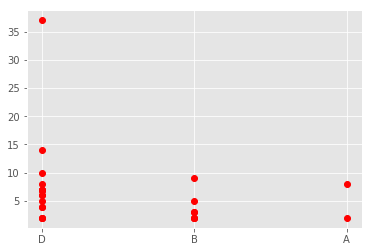

In [23]:
plt.plot(temp.status, temp.times_balance_below_500, "ro")


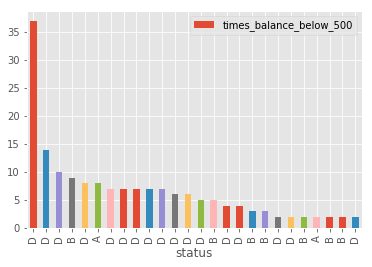

In [24]:
temp.sort_values("times_balance_below_500", ascending=False).plot(
    x="status", y="times_balance_below_500", kind="bar"
)


In [25]:
loan.head(2)


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A


In [26]:
account.head(2)


,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,1993-01-01
1,3818,74,POPLATEK MESICNE,1993-01-01


In [27]:
trans.head(2)


,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1787,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
1,1787,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN


In [28]:
t = loan.loc[:, ["payments", "status"]]
t.head(3)


,payments,status
0,8033.0,B
1,4610.0,A
2,2118.0,A


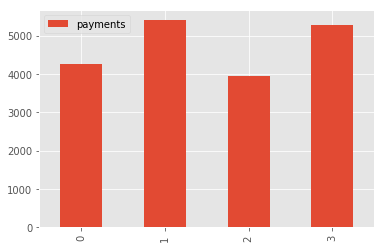

In [29]:
t = t.groupby(["status"], as_index=None).mean()
t.plot(kind="bar")


# Merge tables

In [30]:
df = pd.merge(
    merge_loan_trans,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)


In [31]:
df = pd.merge(
    df,
    order,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_a", "_order"),
    copy=True,
    indicator=False,
    validate=None,
)


In [32]:
df = pd.merge(
    df,
    disp,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_b", "_disp"),
    copy=True,
    indicator=False,
    validate=None,
)


In [33]:
df = pd.merge(
    df,
    card,
    how="left",
    on="disp_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_c", "_card"),
    copy=True,
    indicator=False,
    validate=None,
)


In [34]:
df = pd.merge(
    df,
    client,
    how="left",
    on="client_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_d", "_client"),
    copy=True,
    indicator=False,
    validate=None,
)


In [35]:
district.columns.unique()

Index(['A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13',
       'A14', 'A15', 'A16'],
      dtype='object')

In [36]:
df = pd.merge(
    df,
    district,
    how="left",
    left_on="district_id_client",
    right_on="A1",
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_e", "_district"),
    copy=True,
    indicator=False,
    validate=None,
)
# df = df.drop(["A1"], axis=1, inplace=True)


In [37]:
before_loan_date = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
before_loan_date = before_loan_date.loc[:, ["account_id", "trans_id"]]
trans_pv_k_symbol = pd.merge(
    before_loan_date,
    trans_pv_k_symbol,
    how="left",
    on="trans_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_before", "_df2"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_pv_k_symbol.drop(
    ["account_id_df2", "date", "trans_id"], axis=1, inplace=True
)
trans_pv_k_symbol.rename(columns={"account_id_before": "account_id"}, inplace=True)
trans_pv_k_symbol = trans_pv_k_symbol.groupby(
    by="account_id", axis=0, as_index=False, sort=True, group_keys=True, squeeze=False
).mean()


In [38]:
df

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,5314,1787,1993-07-05,96396,12,8033.0,B,15966.666667,20100.000000,4,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
1,5316,1801,1993-07-11,165960,36,4610.0,A,56036.575862,39688.530000,37,...,7,3,10,73.5,8369,1.79,2.31,117,2854,2618
2,6863,9188,1993-07-28,127080,60,2118.0,A,32168.265000,31202.192857,24,...,6,1,5,53.5,8390,2.28,2.89,132,2080,2122
3,5325,1843,1993-08-03,105804,36,2939.0,A,46378.637500,42535.133333,25,...,10,1,9,74.8,10045,1.42,1.71,135,6604,6295
4,7240,11013,1993-09-06,274740,60,4579.0,A,60804.547059,49872.757143,27,...,5,1,5,50.5,8288,3.79,4.52,110,1562,1460
5,6687,8261,1993-09-13,87840,24,3660.0,A,57919.481818,60175.525000,17,...,1,1,2,41.3,8598,2.77,3.26,123,1597,1875
6,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,7,1,5,51.9,9045,3.13,3.60,124,1845,1879
7,6111,5428,1993-09-24,174744,24,7281.0,B,21443.410526,26301.042857,32,...,6,2,8,80.0,8991,1.39,2.01,128,5198,5273
8,7235,10973,1993-10-13,154416,48,3217.0,A,44006.817647,42201.950000,32,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
9,5997,4894,1993-11-04,117024,24,4876.0,A,54099.455556,61054.633333,13,...,10,1,9,74.8,10045,1.42,1.71,135,6604,6295


In [39]:
df = pd.merge(
    df,
    trans_pv_k_symbol,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_df", "_tt"),
    copy=True,
    indicator=False,
    validate=None,
)


In [40]:
df

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,5314,1787,1993-07-05,96396,12,8033.0,B,15966.666667,20100.000000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5316,1801,1993-07-11,165960,36,4610.0,A,56036.575862,39688.530000,37,...,52.668750,0.0,641.062500,8042.381250,0.000000,7672.262500,9716.193750,14397.412500,0.0,11456.193750
2,6863,9188,1993-07-28,127080,60,2118.0,A,32168.265000,31202.192857,24,...,67.363636,0.0,42.818182,4334.527273,0.000000,3613.072727,0.000000,20087.736364,0.0,3088.436364
3,5325,1843,1993-08-03,105804,36,2939.0,A,46378.637500,42535.133333,25,...,89.088889,0.0,0.000000,0.000000,0.000000,11781.522222,8175.988889,22536.011111,0.0,0.000000
4,7240,11013,1993-09-06,274740,60,4579.0,A,60804.547059,49872.757143,27,...,103.736364,0.0,1727.090909,0.000000,0.000000,3765.009091,7571.272727,26517.281818,0.0,7968.454545
5,6687,8261,1993-09-13,87840,24,3660.0,A,57919.481818,60175.525000,17,...,154.100000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,52758.700000,0.0,0.000000
6,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,35.100000,0.0,579.333333,0.000000,0.000000,4531.350000,3100.733333,8779.761111,0.0,4643.794444
7,6111,5428,1993-09-24,174744,24,7281.0,B,21443.410526,26301.042857,32,...,70.633333,0.0,0.000000,0.000000,0.000000,8350.400000,4795.233333,20643.941667,0.0,0.000000
8,7235,10973,1993-10-13,154416,48,3217.0,A,44006.817647,42201.950000,32,...,92.180000,0.0,0.000000,0.000000,0.000000,0.000000,21531.050000,26575.880000,0.0,0.000000
9,5997,4894,1993-11-04,117024,24,4876.0,A,54099.455556,61054.633333,13,...,143.375000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,42404.350000,0.0,0.000000


In [41]:
df.head()


,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,5314,1787,1993-07-05,96396,12,8033.0,B,15966.666667,20100.000000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5316,1801,1993-07-11,165960,36,4610.0,A,56036.575862,39688.530000,37,...,52.668750,0.0,641.062500,8042.381250,0.0,7672.262500,9716.193750,14397.412500,0.0,11456.193750
2,6863,9188,1993-07-28,127080,60,2118.0,A,32168.265000,31202.192857,24,...,67.363636,0.0,42.818182,4334.527273,0.0,3613.072727,0.000000,20087.736364,0.0,3088.436364
3,5325,1843,1993-08-03,105804,36,2939.0,A,46378.637500,42535.133333,25,...,89.088889,0.0,0.000000,0.000000,0.0,11781.522222,8175.988889,22536.011111,0.0,0.000000
4,7240,11013,1993-09-06,274740,60,4579.0,A,60804.547059,49872.757143,27,...,103.736364,0.0,1727.090909,0.000000,0.0,3765.009091,7571.272727,26517.281818,0.0,7968.454545


# Data Cleaning

In [42]:
df["year_"] = df.date_loan.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_loan"] = 1999 - df.year_
df.drop(["date_loan", "year_"], axis=1, inplace=True)
df.frequency = df.frequency.map(
    {"POPLATEK MESICNE": 30, "POPLATEK TYDNE": 7, "POPLATEK PO OBRATU": 1}
)


In [43]:
df["year_"] = df.date_account.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_account"] = 1999 - df.year_
df.drop(["date_account", "year_", "type_disp"], axis=1, inplace=True)


In [44]:
df.issued.fillna("999999", inplace=True)
df["years_card_issued"] = df.issued.apply(
    lambda x: (99 - int(x[:2])), convert_dtype=int
)
df.drop(["issued","A12","A15"], axis=1, inplace=True)


In [45]:
df.fillna(0, inplace=True)


In [46]:
df.status.value_counts()


C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [47]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 57 columns):
loan_id                         682 non-null int64
account_id                      682 non-null int64
amount                          682 non-null int64
duration                        682 non-null int64
payments                        682 non-null float64
status                          682 non-null object
avg_balance_3M_befroe_loan      682 non-null float64
avg_balance_1M_befroe_loan      682 non-null float64
trans_freq                      682 non-null int64
min_balance_befroe_loan         682 non-null float64
avg_amount_trans_before_loan    682 non-null float64
avg_balance_before_loan         682 non-null float64
times_balance_below_500         682 non-null float64
times_balance_below_5K          682 non-null float64
district_id_d                   682 non-null int64
frequency                       682 non-null int64
order_amount_LEASING            682 non-null float64
order_amo

# Get label

In [48]:
m = {"A": 0, "B": 1, "C": 0, "D": 1}
df.status = df.status.map(m)
df.status.unique()


array([1, 0], dtype=int64)

In [49]:
df = pd.get_dummies(df, drop_first=True)


In [50]:
df.columns.unique()

Index(['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'district_id_d', 'frequency',
       'order_amount_LEASING', 'order_amount_No_symbol',
       'order_amount_POJISTNE', 'order_amount_SIPO', 'order_amount_UVER',
       'disp_id', 'client_id', 'card_id', 'type', 'district_id_client', 'age',
       'sex', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13',
       'A14', 'A16', 'amount_POJISTNE', 'amount_SANKC. UROK', 'amount_SIPO',
       'amount_SLUZBY', 'amount_UROK', 'amount_UVER',
       'amount_k_symbol_missing', 'balance_POJISTNE', 'balance_SANKC. UROK',
       'balance_SIPO', 'balance_SLUZBY', 'balance_UROK', 'balance_UVER',
       'balance_k_symbol_missing', 'years_of_loan', 'years_of_account',
       'years

In [51]:
df.drop(
    [
        "loan_id",
        "account_id",
        "district_id_d",
        "disp_id",
        "client_id",
        "card_id",
        "district_id_client",
    ],
    axis=1,
    inplace=True,
)


In [52]:
df.columns


Index(['amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'frequency', 'order_amount_LEASING',
       'order_amount_No_symbol', 'order_amount_POJISTNE', 'order_amount_SIPO',
       'order_amount_UVER', 'type', 'age', 'sex', 'A1', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16', 'amount_POJISTNE',
       'amount_SANKC. UROK', 'amount_SIPO', 'amount_SLUZBY', 'amount_UROK',
       'amount_UVER', 'amount_k_symbol_missing', 'balance_POJISTNE',
       'balance_SANKC. UROK', 'balance_SIPO', 'balance_SLUZBY', 'balance_UROK',
       'balance_UVER', 'balance_k_symbol_missing', 'years_of_loan',
       'years_of_account', 'years_card_issued'],
      dtype='object')

# Standard processing and Training/Test set Split

In [53]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Draft Modeling: Random Forest

In [54]:
rf = ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [55]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.94      0.99      0.97       184
          1       0.90      0.43      0.58        21

avg / total       0.93      0.94      0.93       205



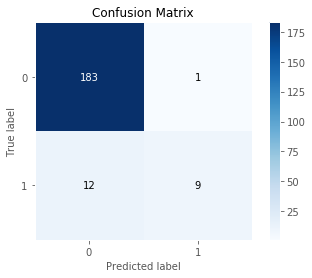

In [56]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [57]:
fi = rf.feature_importances_
fi


array([0.02653242, 0.00704974, 0.03163808, 0.05045512, 0.05799636,
       0.03493745, 0.08215634, 0.0231755 , 0.03946289, 0.04820605,
       0.0794944 , 0.00300753, 0.        , 0.01500287, 0.00149619,
       0.04442245, 0.03709268, 0.00369688, 0.01922017, 0.00234436,
       0.01407506, 0.0104027 , 0.00762688, 0.0077698 , 0.00664005,
       0.00369941, 0.00579161, 0.01090752, 0.01732   , 0.00931213,
       0.01119182, 0.01225555, 0.00117246, 0.05671908, 0.02066498,
       0.02061571, 0.02679048, 0.        , 0.00882044, 0.00116714,
       0.03590737, 0.02112933, 0.02650385, 0.03192085, 0.        ,
       0.00258642, 0.01168014, 0.00726028, 0.00268144])

In [58]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)


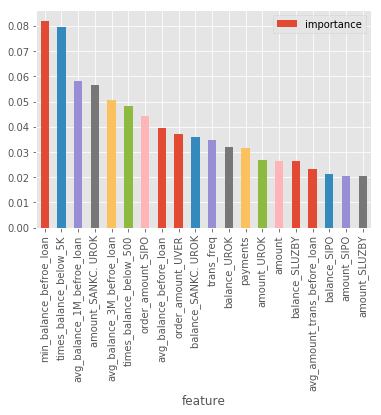

In [59]:
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:20].plot(x="feature", y="importance", kind="bar")


# Visualization & Feature Selection

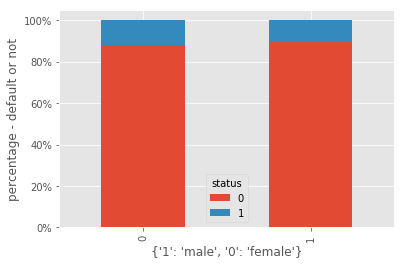

In [60]:
df.groupby(["sex", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel({"1": "male", "0": "female"})
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()


In [61]:
df.groupby(["sex", "status"])["status"].size()


sex  status
0    0         307
     1          41
1    0         299
     1          35
Name: status, dtype: int64

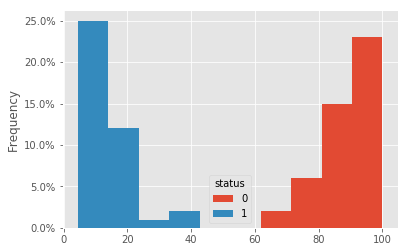

In [62]:
df.groupby(["age", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="hist", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


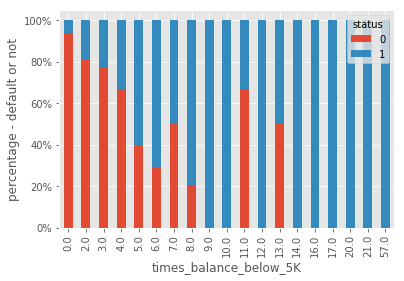

In [63]:
df.groupby(["times_balance_below_5K", "status"])["status"].size().groupby(
    level=0
).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()


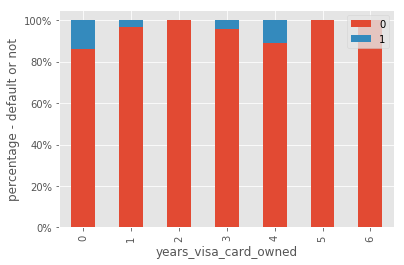

In [64]:
df.groupby(["years_card_issued", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.xlabel("years_visa_card_owned")
plt.legend(loc=1)
plt.show()


Text(0,0.5,'count_of_loan_id')

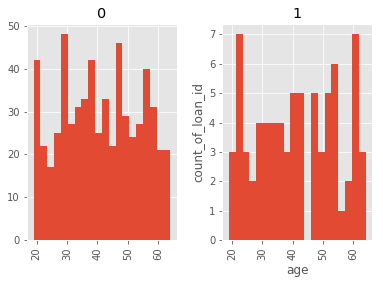

In [65]:
df.hist(column="age", by="status", bins=20)
plt.xlabel("age")
plt.ylabel("count_of_loan_id")


In [66]:
# Binning:
def binning(col, cut_points, labels=None):
    # Define min and max values:
    minval = col.min()
    maxval = col.max()

    # create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points) + 1)

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin


# Binning age:
cut_points = [24, 34, 44, 50]
labels = ["20", "25", "35", "45", "50"]
df["age_bin"] = binning(df["age"], cut_points, labels)


Text(0,0.5,'percentage - default or not')

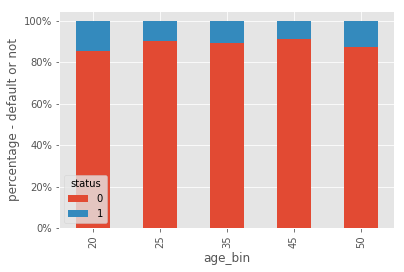

In [67]:
df.groupby(["age_bin", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylabel("percentage - default or not")


In [68]:
df[df.status == 1].head()


,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,...,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued,age_bin
0,96396,12,8033.0,1,15966.666667,20100.000000,4,1100.0,5025.000000,12250.000000,...,0.0,0.000,0.000000,0.000000,0.0,0.000,6,6,0,50
7,174744,24,7281.0,1,21443.410526,26301.042857,32,1000.0,11557.950000,37485.456250,...,0.0,8350.400,4795.233333,20643.941667,0.0,0.000,6,6,0,50
12,464520,60,7742.0,1,43137.355556,62808.846154,68,200.0,13335.798529,51760.016176,...,0.0,0.000,21409.662500,27223.631250,0.0,0.000,6,6,0,50
19,75624,24,3151.0,1,55333.050000,57562.000000,23,400.0,13406.739130,50009.908696,...,0.0,4195.480,0.000000,45769.340000,0.0,0.000,6,6,0,35
28,49320,12,4110.0,1,44874.806452,40374.653846,49,900.0,10548.359184,46576.277551,...,0.0,9223.925,12802.725000,13012.725000,0.0,8296.075,5,6,0,50


Text(0,0.5,'payments')

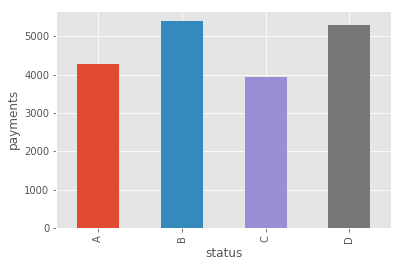

In [69]:
a = loan.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
a.payments.mean().plot(kind="bar")
plt.ylabel("payments")


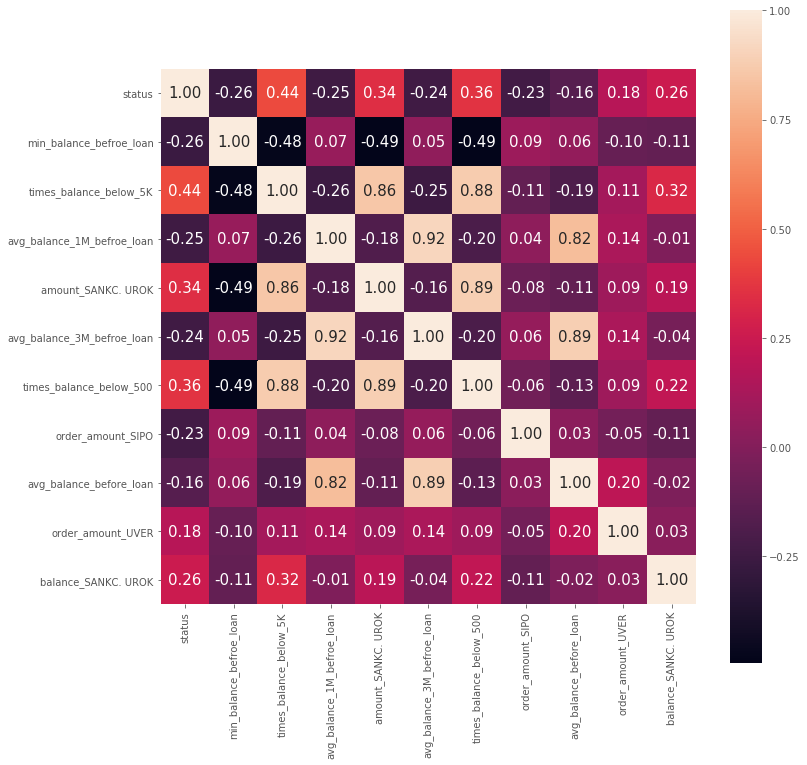

In [70]:
# plot heatmap
import seaborn as sns

cols = list(importance.feature[:10])
cols.insert(0, "status")
corrcoef_map = np.corrcoef(df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    corrcoef_map,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)


In [71]:
df.columns.unique()


Index(['amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'frequency', 'order_amount_LEASING',
       'order_amount_No_symbol', 'order_amount_POJISTNE', 'order_amount_SIPO',
       'order_amount_UVER', 'type', 'age', 'sex', 'A1', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16', 'amount_POJISTNE',
       'amount_SANKC. UROK', 'amount_SIPO', 'amount_SLUZBY', 'amount_UROK',
       'amount_UVER', 'amount_k_symbol_missing', 'balance_POJISTNE',
       'balance_SANKC. UROK', 'balance_SIPO', 'balance_SLUZBY', 'balance_UROK',
       'balance_UVER', 'balance_k_symbol_missing', 'years_of_loan',
       'years_of_account', 'years_card_issued', 'age_bin'],
      dtype='object')

# Create X, y, training/testing set split

In [72]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Modeling: Random Forest

In [73]:
rf = ensemble.RandomForestClassifier(
    n_estimators=800,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [74]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.92      1.00      0.96       178
          1       1.00      0.41      0.58        27

avg / total       0.93      0.92      0.91       205



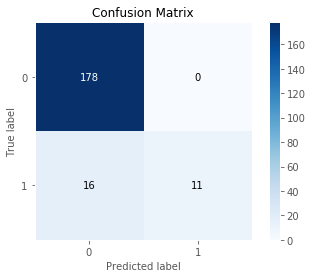

In [75]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [76]:
fi = rf.feature_importances_
fi


array([0.02761553, 0.00888717, 0.02896173, 0.03610551, 0.04048777,
       0.03327116, 0.08297194, 0.02058933, 0.03565726, 0.06963813,
       0.06887262, 0.00475938, 0.        , 0.007363  , 0.00464257,
       0.04027054, 0.02867009, 0.00187138, 0.01964948, 0.00340574,
       0.01290729, 0.01270513, 0.01524715, 0.01449648, 0.01162585,
       0.00623417, 0.00708567, 0.01275356, 0.01631448, 0.0139492 ,
       0.01574372, 0.01222991, 0.00086142, 0.06288474, 0.01535452,
       0.02404353, 0.02198646, 0.        , 0.0051343 , 0.00081951,
       0.03485529, 0.01995056, 0.02843345, 0.02504027, 0.        ,
       0.00767587, 0.01534043, 0.01265248, 0.00331449, 0.00666977])

In [77]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)


Text(0,0.5,'importance')

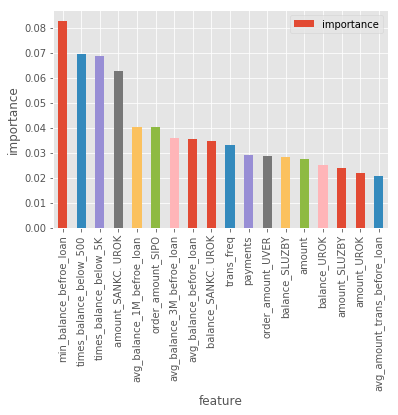

In [78]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")
plt.ylabel("importance")


# Decision Tree

In [79]:
clf = tree.DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort=False,
)

model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [80]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.95      1.00      0.98       178
          1       1.00      0.67      0.80        27

avg / total       0.96      0.96      0.95       205



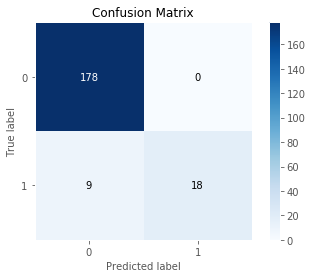

In [81]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


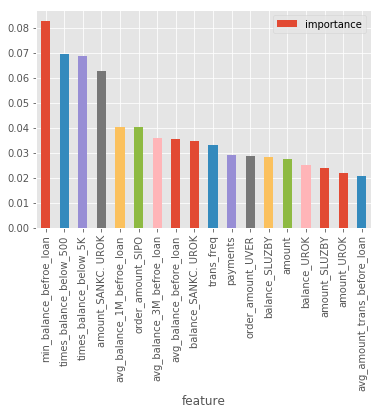

In [82]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")


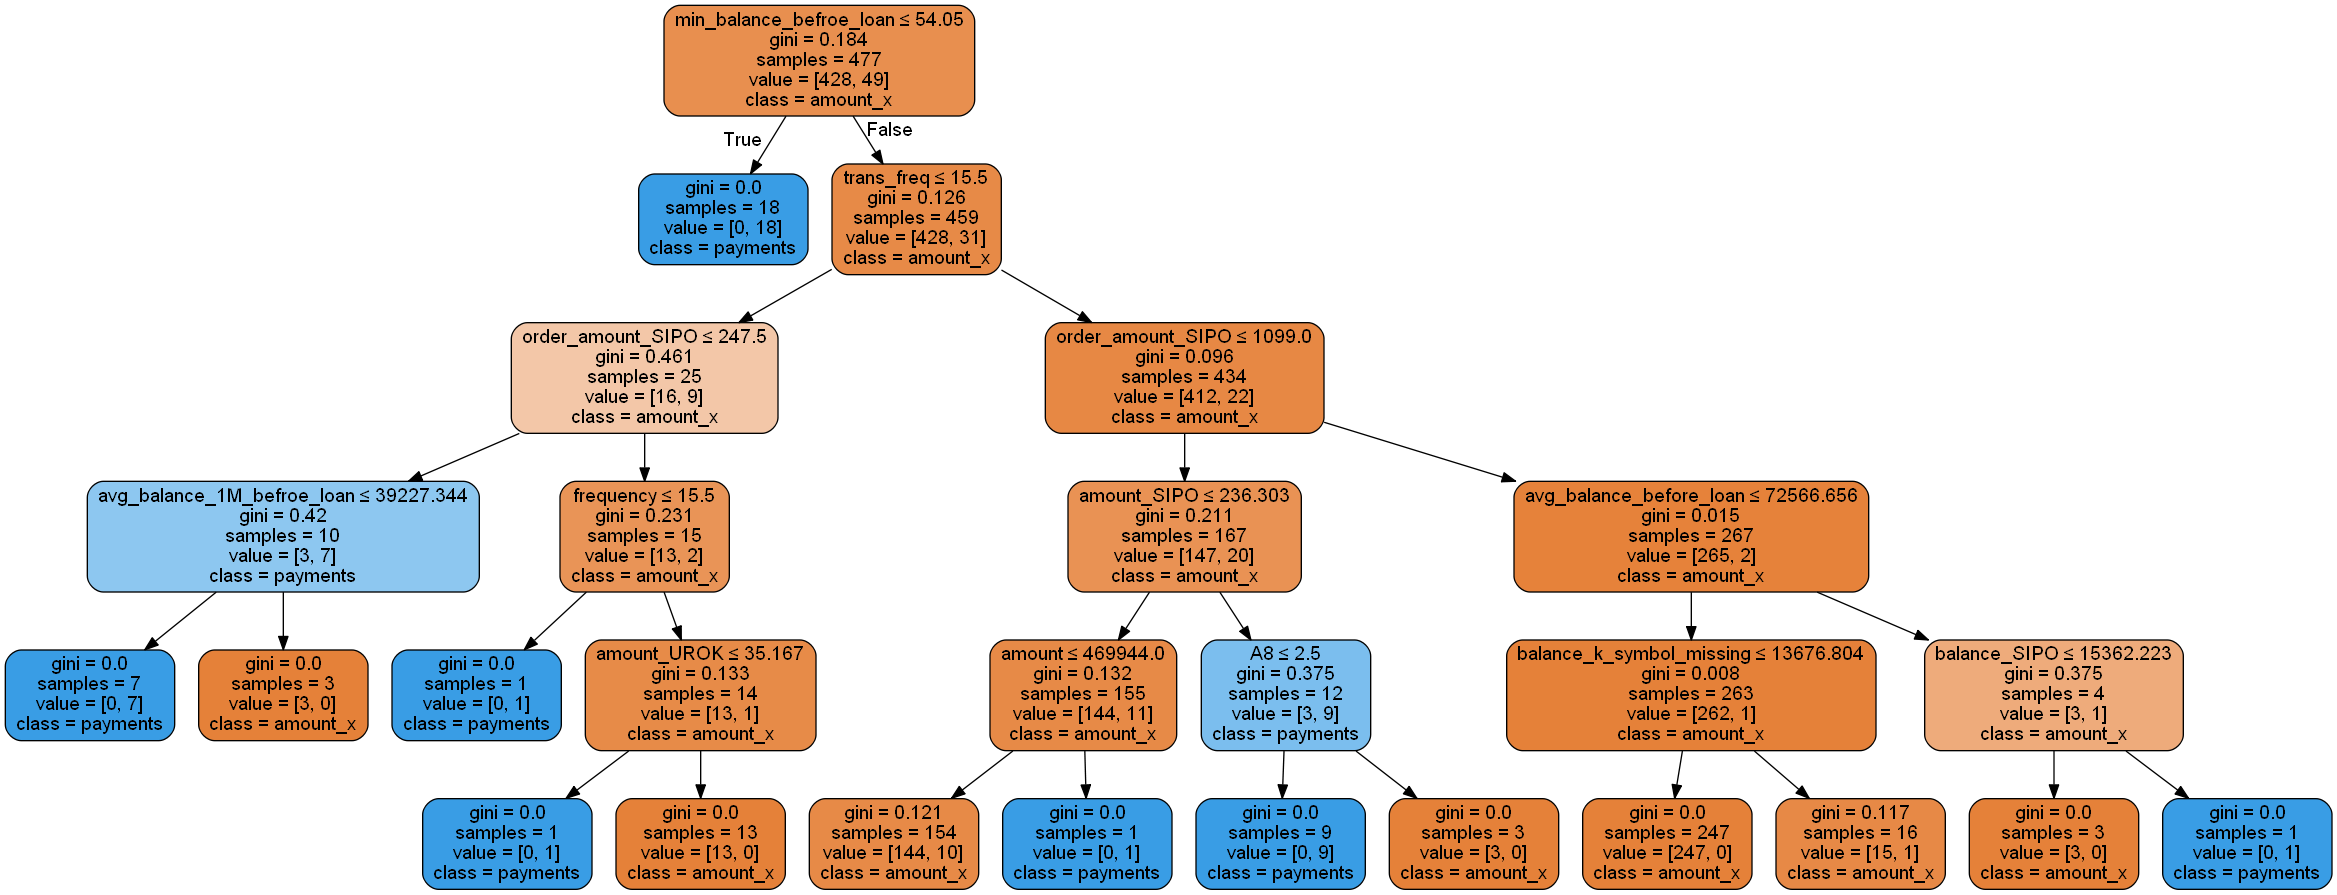

In [83]:
clf.fit(X_train, y_train)
# create a Graphviz file
from sklearn.tree import export_graphviz
from IPython.display import Image
import pylab, pydotplus
from sklearn.externals.six import StringIO

feature_cols = X_test.columns
dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    feature_names=feature_cols,
    class_names=["amount_x", "payments"],
    filled=True,
    rounded=True,
    leaves_parallel=False,
    rotate=False,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


# Gradient Boosting Classifier

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    loss="deviance",
    learning_rate=0.1,
    n_estimators=200,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
)
model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [85]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.93      0.99      0.96       178
          1       0.88      0.52      0.65        27

avg / total       0.92      0.93      0.92       205



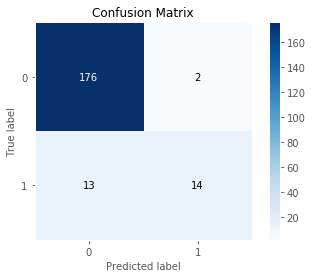

In [86]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Feature Scaling - for SVM & Logistic Regression

In [87]:
# Standard processing
sc = StandardScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# SVM

In [88]:
svc = svm.SVC(
    C=5,
    kernel="rbf",
    degree=3,
    gamma="auto",
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape="ovr",
    random_state=None,
)
model = svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)


In [89]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.96      0.99      0.98       188
          1       0.83      0.59      0.69        17

avg / total       0.95      0.96      0.95       205



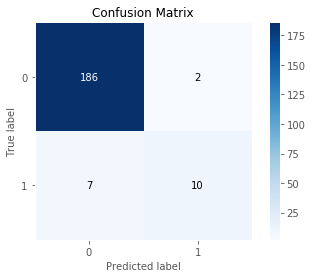

In [90]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Logistic Regression

In [91]:
lr = LogisticRegression(penalty="l2", C=1).fit(X_train, y_train)
y_pred = lr.predict(X_test)


In [92]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.97      0.98      0.98       188
          1       0.75      0.71      0.73        17

avg / total       0.96      0.96      0.96       205



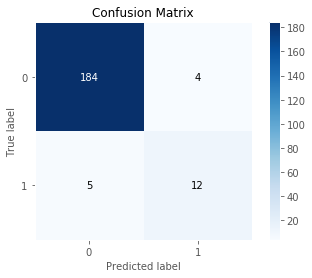

In [93]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Try two features only to plot Decision Boundary

In [94]:
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha=0.6)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, alpha=0.6)


In [95]:
X = df[["min_balance_befroe_loan", "times_balance_below_5K"]]
y = df["status"]


In [96]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)

X_train, X_test, y_train, y_test = train_test_split(X, y)
model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_pred, y_test)
f1


0.3636363636363637

In [97]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.94      0.97      0.96       158
          1       0.44      0.31      0.36        13

avg / total       0.91      0.92      0.91       171



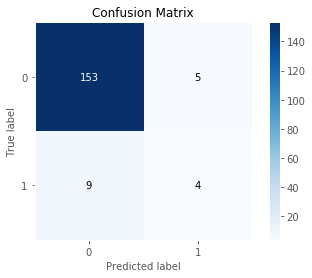

In [98]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


Text(0,0.5,'times_balance_below_5K')

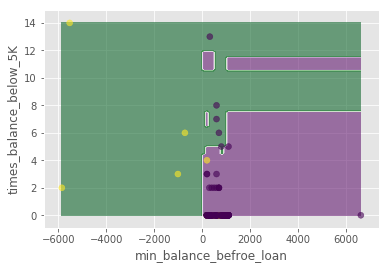

In [99]:
plot_decision_boundary(model, X_test, y_test)
plt.xlabel("min_balance_befroe_loan")
plt.ylabel("times_balance_below_5K")


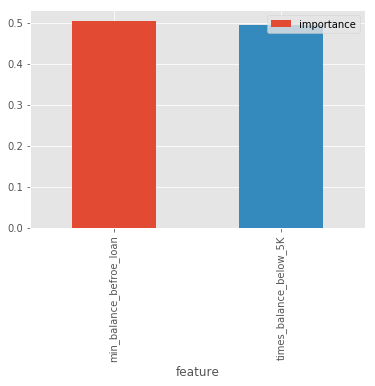

In [100]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")
